# Assignment Sheet 2

## Assignment 2.1

What filter techniques from the feature selection framework can be applied for a text classification task? What filters are not, or at least less, suitable for text? Justify your answer under a careful reconsideration of the nature of the features in use! For simplicity just assume a Bag-Of-Words representation of the text.

In the BOW framework, each word is a separate feature with a numerical value representing how many times it was recorded in each document. The first step is selecting which filter method is best for feature selection in this context is to consider the distribution of the words - it is unlikely the words will follow a normal distribution (exponential is more likely). Therefore, simple parametric filters like ANOVA and t-test are not suitable.

Mutual information filtering can be used as it quantifies the amount of information shared between a class label and a feature. This is a useful method in our case. Similarly, the chi-square test is useful as it can compare observed vs expected values and determine whether certain words appear more often than we would expect it by chance in each class. The most informative words should be retained (features selected) and the others potentially disregarded (features to be ignored).

## Assignment 2.2

Implement suitable filters (or use methods from Python Sk-learn or similar tool-kits) for a classification task of your own choice! Report performance measures (you can consider a benchmark dataset like 20 Newsgroups) of your classifiers in respect to the filtered features, e.g. on a regular grid (50, 100, 150, 200, 250, ...) of feature set sizes. Provide plots where ever possible to explain your answer.

0.7110993096123208
0.6999468932554435
0.6818906001062135
0.6509559214020181
0.6319702602230484
0.6007700477960701
0.536510886882634
0.4642857142857143


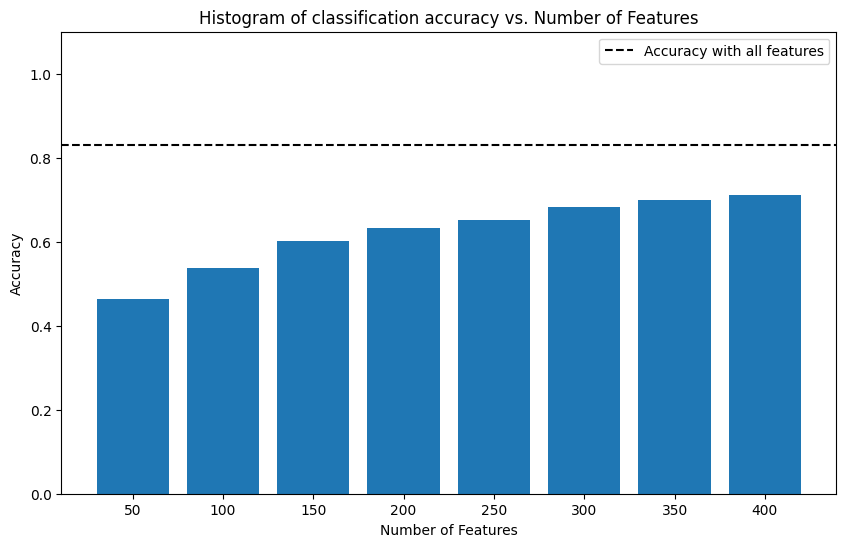

In [10]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.naive_bayes import ComplementNB
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import vstack


def load_dataset():
    """Load and vectorise the 20 newsgroups dataset."""
    data_train = fetch_20newsgroups(subset="train", random_state=42)
    data_test = fetch_20newsgroups(subset="test", random_state=42)

    target_names = data_train.target_names
    y_train, y_test = data_train.target, data_test.target

    vectoriser = TfidfVectorizer(stop_words="english")
    X_train = vectoriser.fit_transform(data_train.data)
    X_test = vectoriser.transform(data_test.data)
    feature_names = vectoriser.get_feature_names_out()

    return X_train, X_test, y_train, y_test, feature_names, target_names

def benchmark(clf, custom_name=False):
    print("_" * 80)
    print("Training: ")
    print(clf)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    score = metrics.accuracy_score(y_test, pred)
    print(f"accuracy:   {score:.3}")

    if hasattr(clf, "coef_"):
        print(f"dimensionality: {clf.coef_.shape[1]}")
        print(f"density: {density(clf.coef_)}")
        print()

    print()
    if custom_name:
        clf_descr = str(custom_name)
    else:
        clf_descr = clf.__class__.__name__
    return clf_descr, score


# Load data with all class labels, perform train/test split 
X_train, X_test, y_train, y_test, feature_names, target_names = load_dataset()

# We will need this for the feature reduction 
X_combined = vstack([X_train, X_test])
y_combined = np.hstack([y_train, y_test])

# First, determine the classification accuracy without removing any features 
clf_all_f = ComplementNB(alpha=0.1) # Initiate the classifier 
clf_all_f.fit(X_train, y_train) # Train on all data
best_accuracy = clf_all_f.score(X_test, y_test) # Obtain classification accuracy score 

# Feature selection and classification. For the filter, we are going to use the chi-squared test. 
# This is fair since the sample sizes are quite large 
score_list = []
features_n = [400, 350, 300, 250, 200, 150, 100, 50]
for features in features_n:
    X_new = SelectKBest(chi2, k=features).fit_transform(X_combined, y_combined)
    clf = ComplementNB(alpha=0.1)
    clf.fit(X_new[:len(y_train)], y_train)  # Train on the original training data
    pred = clf.predict(X_new[len(y_train):])  # Test on the original test data
    score = metrics.accuracy_score(y_test, pred)
    score_list.append(score)
    print(score)

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(features_n, score_list, width=40,)
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.title('Histogram of classification accuracy vs. Number of Features')
plt.grid(False)
plt.axhline(y=best_accuracy, color='black', linestyle='--', label='Accuracy with all features')
plt.legend()
plt.ylim([0, 1.1])
plt.show()
